<a href="https://colab.research.google.com/github/Shujaat123/COE691_XAI/blob/main/3)_CNN_explainability_(PyTorch_%2B_Captum)_Saliency%2C_Integrated_Gradients%2C_Grad_CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COE 691 – Special Topics in Computer Engineering I (Explainable Artificial Intelligence)

## Demo 3: CNN explainability (PyTorch + Captum) Saliency, Integrated Gradients, Grad-CAM

0) Problem & Setup (what we’re solving)

In [1]:
# Problem statement: classify handwritten digits (0–9) from 8×8 grayscale images.
# We train a small CNN, evaluate it, and generate explanations for specific predictions:
#   • Saliency (input gradients)
#   • Integrated Gradients (baseline→input path)
#   • Grad-CAM (conv-layer importance heatmap)
#
# Dataset: sklearn 'digits' (built-in, 1797 samples, 8×8 pixels, no internet required).

import numpy as np
import matplotlib.pyplot as plt
import torch, torch.nn as nn, torch.nn.functional as F
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


Device: cpu


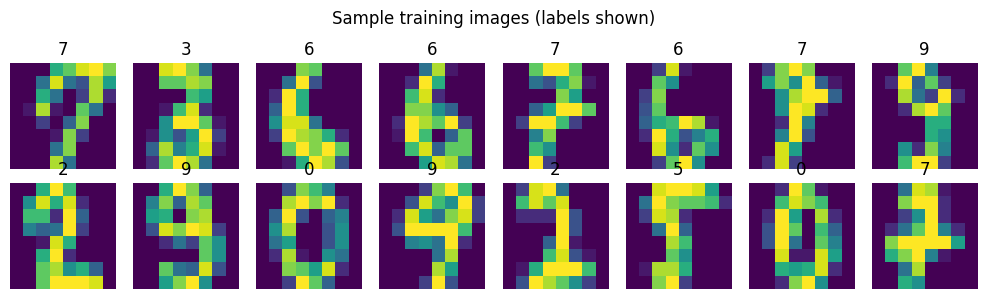

In [2]:
# Load digits and prepare tensors
digits = load_digits()
X = digits.images.astype(np.float32) / 16.0    # scale to [0,1]
y = digits.target
X = X[:, None, :, :]                           # add channel dim -> (N, 1, 8, 8)

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.25, random_state=0, stratify=y)

# Quick grid of samples
def show_grid(Xb, yb, title=""):
    n = min(16, len(Xb))
    cols, rows = 8, int(np.ceil(n/8))
    plt.figure(figsize=(10, 3))
    for i in range(n):
        plt.subplot(rows, cols, i+1)
        plt.imshow(Xb[i,0], interpolation="nearest")
        plt.title(str(yb[i]))
        plt.axis("off")
    if title: plt.suptitle(title)
    plt.tight_layout(); plt.show()

show_grid(Xtr[:16], ytr[:16], "Sample training images (labels shown)")


2) Model: Small CNN (8×8 → 4×4 → 2×2)

In [3]:
class SmallCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)   # 8x8 -> 8x8
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)  # 4x4 -> 4x4 (after pool)
        self.fc    = nn.Linear(32*2*2, 10)            # after two 2×2 pools: 8->4->2

        # Hooks for Grad-CAM
        self._feat = None
        self._grad = None
        def fwd_hook(m, inp, out): self._feat = out.detach()
        def bwd_hook(m, gin, gout): self._grad = gout[0].detach()
        self.conv2.register_forward_hook(fwd_hook)
        self.conv2.register_full_backward_hook(bwd_hook)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)   # 8->4
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)   # 4->2
        x = x.reshape(x.size(0), -1)
        return self.fc(x)

model = SmallCNN().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

Xt = torch.tensor(Xtr, device=device)
Xv = torch.tensor(Xte, device=device)
yt = torch.tensor(ytr, device=device, dtype=torch.long)
yv = torch.tensor(yte, device=device, dtype=torch.long)


3) Train & Evaluate

In [4]:
model.train()
batch = 128
for epoch in range(5):
    perm = torch.randperm(len(Xt))
    for i in range(0, len(Xt), batch):
        idx = perm[i:i+batch]
        xb, yb = Xt[idx], yt[idx]
        opt.zero_grad()
        loss = F.cross_entropy(model(xb), yb)
        loss.backward()
        opt.step()
    model.eval()
    with torch.no_grad():
        acc = (model(Xv).argmax(1) == yv).float().mean().item()
    print(f"Epoch {epoch+1}: val acc = {acc:.3f}")
    model.train()

# Final evaluation
model.eval()
with torch.no_grad():
    logits = model(Xv)
    preds = logits.argmax(1).cpu().numpy()
acc = accuracy_score(yte, preds)
cm  = confusion_matrix(yte, preds)
print("\nAccuracy:", round(acc,3))
print("Confusion matrix:\n", cm)
print("\nReport:\n", classification_report(yte, preds))


Epoch 1: val acc = 0.353
Epoch 2: val acc = 0.611
Epoch 3: val acc = 0.802
Epoch 4: val acc = 0.807
Epoch 5: val acc = 0.853

Accuracy: 0.853
Confusion matrix:
 [[44  0  0  0  0  0  1  0  0  0]
 [ 0 26  3  0  9  1  2  0  1  4]
 [ 0  1 40  0  0  0  0  3  0  0]
 [ 0  0  0 42  0  0  1  1  2  0]
 [ 0  0  0  0 43  0  2  0  0  0]
 [ 0  0  0  0  3 41  0  0  0  2]
 [ 0  0  0  0  3  0 42  0  0  0]
 [ 0  0  0  0  0  3  0 41  0  1]
 [ 0  0  0  0  7  5  2  2 27  0]
 [ 0  0  0  0  4  1  0  2  0 38]]

Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99        45
           1       0.96      0.57      0.71        46
           2       0.93      0.91      0.92        44
           3       1.00      0.91      0.95        46
           4       0.62      0.96      0.75        45
           5       0.80      0.89      0.85        46
           6       0.84      0.93      0.88        45
           7       0.84      0.91      0.87        45
           

4) Explanations: Saliency, Integrated Gradients, Grad-CAM (from scratch)

In [5]:
# --- Saliency (grad wrt input) ---
def saliency(model, x, target_idx):
    x = x.clone().detach().requires_grad_(True)
    out = model(x)
    score = out[0, target_idx]
    model.zero_grad()
    score.backward()
    return x.grad.detach().cpu().numpy()[0]  # (1,8,8)

# --- Integrated Gradients ---
def integrated_gradients(model, x, target_idx, baseline=None, steps=32):
    if baseline is None:
        baseline = torch.zeros_like(x)
    grads = []
    for i in range(1, steps+1):
        xi = baseline + (float(i)/steps) * (x - baseline)
        xi = xi.clone().detach().requires_grad_(True)
        out = model(xi)
        score = out[0, target_idx]
        model.zero_grad()
        score.backward()
        grads.append(xi.grad.detach().cpu().numpy())
    avg_grad = np.mean(np.stack(grads, axis=0), axis=0)   # (1,1,8,8)
    ig = (x.detach().cpu().numpy() - baseline.detach().cpu().numpy()) * avg_grad
    return ig[0]  # (1,8,8)

# --- Grad-CAM on conv2 using feature/grad hooks ---
def grad_cam(model, x, target_idx):
    out = model(x)
    score = out[0, target_idx]
    model.zero_grad()
    score.backward()
    feat = model._feat.cpu().numpy()[0]   # (C,H,W)
    grad = model._grad.cpu().numpy()[0]   # (C,H,W)
    weights = grad.mean(axis=(1,2), keepdims=True)        # GAP over H,W
    cam = np.maximum(0, (weights * feat).sum(axis=0))     # ReLU(weighted sum)
    return cam  # (H,W)


5) Visualize Original + Saliency + IG + Grad-CAM

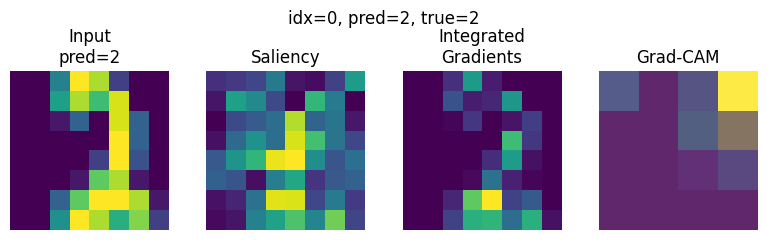

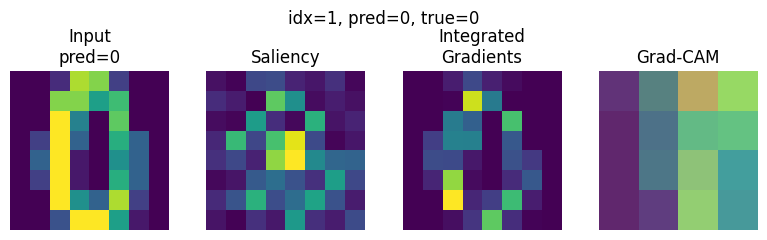

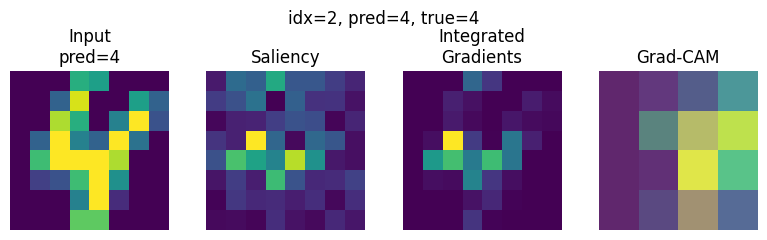

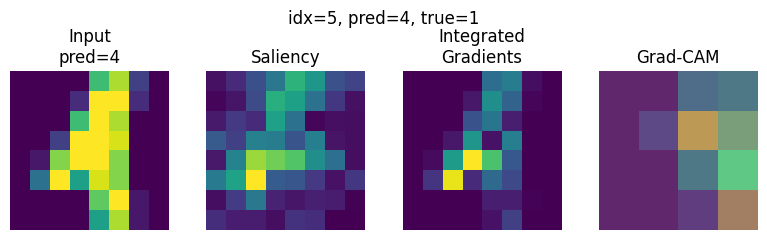

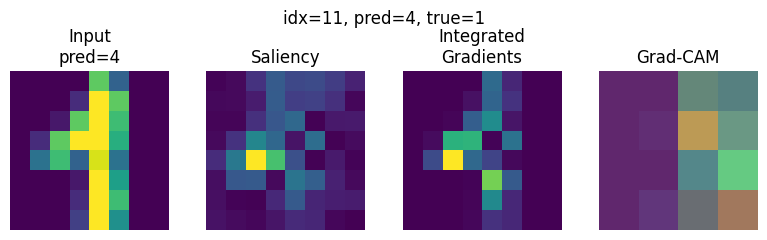

In [6]:
def plot_attributions(x_img, pred_class, sal, ig, cam, title=""):
    plt.figure(figsize=(8, 2.4))

    ax = plt.subplot(1,4,1); ax.imshow(x_img[0], interpolation="nearest"); ax.set_title(f"Input\npred={pred_class}"); ax.axis("off")
    ax = plt.subplot(1,4,2); ax.imshow(np.abs(sal[0]), interpolation="nearest"); ax.set_title("Saliency"); ax.axis("off")
    ax = plt.subplot(1,4,3); ax.imshow(np.abs(ig[0]), interpolation="nearest"); ax.set_title("Integrated\nGradients"); ax.axis("off")

    cam_n = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
    ax = plt.subplot(1,4,4)
    ax.imshow(x_img[0], interpolation="nearest", alpha=0.7)
    ax.imshow(cam_n, interpolation="nearest", alpha=0.5)
    ax.set_title("Grad-CAM"); ax.axis("off")

    if title: plt.suptitle(title)
    plt.tight_layout(); plt.show()

# Explain a few correct and incorrect examples
preds_np = preds
correct_idx = np.where(preds_np == yte)[0][:3]
wrong_idx   = np.where(preds_np != yte)[0][:2]

def explain_index(i):
    x = torch.tensor(Xte[i:i+1], device=device)
    pred = int(model(x).argmax(1).item())
    s  = saliency(model, x, pred)
    ig = integrated_gradients(model, x, pred, steps=32)
    gc = grad_cam(model, x, pred)
    plot_attributions(Xte[i], pred, s, ig, gc, title=f"idx={i}, pred={pred}, true={yte[i]}")

for i in correct_idx: explain_index(int(i))
for i in wrong_idx:   explain_index(int(i))


6) Make it interactive (optional)

In [11]:
# from ipywidgets import interact, IntSlider

# def _expl(i=0):
#     i = int(max(0, min(len(Xte)-1, i)))
#     explain_index(i)

# interact(_expl, i=IntSlider(min=0, max=len(Xte)-1, step=1, value=0));

## Same analysis as above using [Captum explanations]

In [8]:
!pip install captum

In [9]:
# PyTorch CNN on MNIST with Captum explanations
# !pip -q install captum torchvision > /dev/null
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from captum.attr import Saliency, IntegratedGradients, LayerGradCam
from captum.attr import visualization as viz

device = 'cuda' if torch.cuda.is_available() else 'cpu'
tfm = transforms.Compose([transforms.ToTensor()])
train = datasets.MNIST(root='./data', train=True, download=True, transform=tfm)
test  = datasets.MNIST(root='./data', train=False, download=True, transform=tfm)
train_loader = DataLoader(train, batch_size=128, shuffle=True)
test_loader  = DataLoader(test,  batch_size=512, shuffle=False)

class SmallCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc    = nn.Linear(32*7*7, 10)
    def forward(self,x):
        x = F.relu(self.conv1(x)); x = F.max_pool2d(x,2)
        x = F.relu(self.conv2(x)); x = F.max_pool2d(x,2)
        self.feat = x
        x = x.view(x.size(0), -1)
        return self.fc(x)

model = SmallCNN().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

# quick/rough training
model.train()
for epoch in range(1):
    for xb,yb in train_loader:
        xb,yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        loss = F.cross_entropy(model(xb), yb)
        loss.backward(); opt.step()

# pick one test image
model.eval()
xb,yb = next(iter(test_loader))
xb,yb = xb.to(device), yb.to(device)
logits = model(xb)
pred = logits.argmax(1)

# Saliency
sal = Saliency(model)
attributions = sal.attribute(xb, target=pred, abs=False).detach().cpu()

# Integrated Gradients
ig = IntegratedGradients(model)
ig_attr = ig.attribute(xb[:8], target=pred[:8], n_steps=32).detach().cpu()

# Grad-CAM on conv2
layer_gc = LayerGradCam(model, model.conv2)
gc_attr = layer_gc.attribute(xb[:8], target=pred[:8]).detach().cpu()
gc_attr = F.interpolate(gc_attr, size=(28,28), mode='bilinear', align_corners=False)

print("Predicted labels:", pred[:8].cpu().numpy())
# Quick sanity numeric summaries
print("Saliency stats:", attributions[:8].abs().mean().item(), "IG stats:", ig_attr.abs().mean().item(), "GradCAM stats:", gc_attr.abs().mean().item())


100%|██████████| 1.65M/1.65M [00:00<00:00, 4.73MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.2MB/s]
/usr/local/lib/python3.12/dist-packages/captum/attr/_core/saliency.py:129: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  gradient_mask = apply_gradient_requirements(inputs_tuple)


Predicted labels: [7 2 1 0 4 1 4 9]
Saliency stats: 0.06100695952773094 IG stats: 0.017015069723129272 GradCAM stats: 0.00423738406971097


| Metric                        | What it measures                      | Typical magnitude | Interpretation                      |
| :---------------------------- | :------------------------------------ | :---------------- | :---------------------------------- |
| **Saliency**                  | Raw gradient w.r.t. pixels            | ~0.05             | Sensitive pixels; often noisy       |
| **Integrated Gradients (IG)** | Average gradients along input path    | ~0.01–0.02        | Smoother, more reliable attribution |
| **Grad-CAM**                  | Region-level importance at conv layer | ~0.005            | Highlights *where* the CNN looked   |


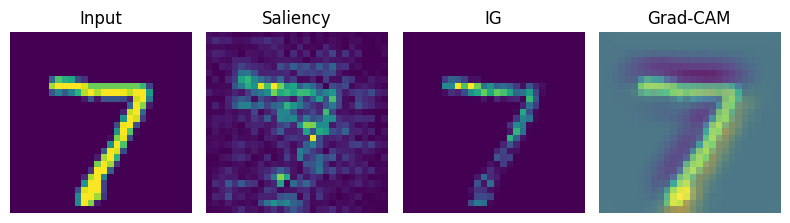

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

def show_attr_grid(x, sal, ig, gc, idx=0):
    x0 = x[idx,0].cpu().numpy()
    s0 = np.abs(sal[idx,0].cpu().numpy())
    ig0 = np.abs(ig[idx,0].cpu().numpy())
    gc0 = gc[idx,0].cpu().numpy()
    gc0 = (gc0 - gc0.min())/(gc0.max()-gc0.min()+1e-8)

    plt.figure(figsize=(8,2.4))
    ax=plt.subplot(1,4,1); ax.imshow(x0); ax.set_title("Input"); ax.axis("off")
    ax=plt.subplot(1,4,2); ax.imshow(s0); ax.set_title("Saliency"); ax.axis("off")
    ax=plt.subplot(1,4,3); ax.imshow(ig0); ax.set_title("IG"); ax.axis("off")
    ax=plt.subplot(1,4,4); ax.imshow(x0, alpha=0.7); ax.imshow(gc0, alpha=0.5); ax.set_title("Grad-CAM"); ax.axis("off")
    plt.tight_layout(); plt.show()

# Example:
show_attr_grid(xb, attributions, ig_attr, gc_attr, idx=0)
